In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
import glob
%matplotlib inline

# useful func
def zscore(x):
    return (x - x.mean())/x.std()

#define a colormap
# Invert the values of the bwr colormap (to get black background)
my_cmap = 1 - matplotlib.cm.bwr(np.arange(256))
my_cmap[:,3] = 1
cmp = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', my_cmap)

Load data from files

In [93]:
fList = glob.glob('./*.pkl')
dfList = []
for file in fList:
    currDF = pd.read_pickle(file)
    # clean the data during the loading procedure to keep memory cost low
    goodEntries = (currDF['trip_time_in_secs'] > 0) & (currDF['trip_time_in_secs'] < np.inf) &\
    (currDF['trip_distance'] > 0) & (currDF['trip_distance'] < np.inf) &\
    (currDF['pickup_day_of_week'] <= 5) & (currDF['pickup_hour'].isin([18,19,20]))
    currDF = currDF[goodEntries]
    goodEntries2 = (currDF[['trip_time_in_secs', 'trip_distance']].apply(zscore) < 10).all(axis=1)
    currDF = currDF[goodEntries2]
    dfList.append(currDF)
    
df = pd.concat(dfList)
df.head()

,pickup_date,pickup_day_of_year,pickup_day_of_Month,pickup_day_of_week,pickup_month,pickup_hour,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
218,2013-07-10 20:59:00,191,10,2,7,20,1,1560,6.328125,-73.994400,40.751015,-73.991859,40.689510
1281,2013-07-10 18:48:00,191,10,2,7,18,1,1320,2.869141,-74.008217,40.725868,-73.979317,40.752983
1282,2013-07-10 18:58:00,191,10,2,7,18,1,780,3.189453,-73.981827,40.776176,-73.952789,40.810837
1283,2013-07-10 18:44:00,191,10,2,7,18,1,1740,3.599609,-73.992538,40.743298,-73.958588,40.778873
1284,2013-07-10 18:48:00,191,10,2,7,18,1,1440,1.910156,-73.979752,40.743336,-74.005890,40.750053


Joint histogram of lattitude and longitude

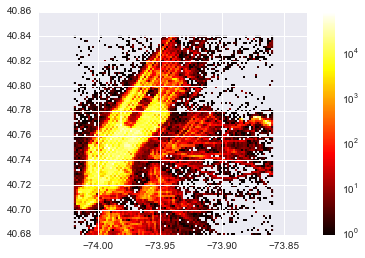

In [183]:
histBinsLo = np.linspace(-74.02,-73.86,100)
histBinsLa = np.linspace(40.68,40.84,100)
x = df['pickup_longitude'].values
y = df['pickup_latitude'].values
counts, xBin, yBin, ax = plt.hist2d(x,y,bins=[histBinsLo, histBinsLa],norm=matplotlib.colors.LogNorm(),cmap='hot')
limits = plt.axis('equal')
plt.colorbar()

Only use bins with count above certain threshold

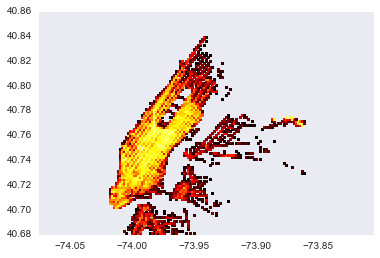

In [162]:
masked_counts = np.ma.masked_where(counts<50,counts)
plt.pcolormesh(xBin,yBin,masked_counts.T,norm=matplotlib.colors.LogNorm(),cmap='hot')
limits = plt.axis('equal')

Now load weather data

In [96]:
weather_df = pd.read_pickle('../WEATHER/clean_weather.pkl')
weather_df['AbsoluteDay'] = weather_df['AbsoluteDay'] + 182 #to bring both dataframes to the same scale
weather_df.drop(['Time','Number'],axis=1,inplace=True) #don't need these
#make columns match in both dataFrames
weather_df.rename(columns={'AbsoluteDay':'pickup_day_of_year', 'Month':'pickup_month',
                           'DayOfMonth':'pickup_day_of_Month','DayOfWeek':'pickup_day_of_week',
                           'Hour':'pickup_hour'}, inplace=True)
weather_df['PrecipitationIn'].fillna(0, inplace=True) #I'm assuming NaNs are no percip
weather_df['rain'] = weather_df['Conditions'].map(lambda x: 'Rain' in x)
joint_df = pd.merge(df, weather_df, how='inner')

Calculate joint histograms for rainy and non-rainy days

In [137]:
#Calculate a histogram for avg trips per day (in the defined window) on rainy days
xRain = joint_df['pickup_longitude'][(joint_df['pickup_hour']==19) &
                                     (joint_df['pickup_day_of_week']<=5) &
                                     (joint_df['rain'])].values
yRain = joint_df['pickup_latitude'][(joint_df['pickup_hour']==19) &
                                     (joint_df['pickup_day_of_week']<=5) &
                                     (joint_df['rain'])].values
countRain, xBin, yBin = np.histogram2d(xRain,yRain,bins=[histBinsLo, histBinsLa])
# Number of rainy days (in the specified window) in the dataset
nRainyDays = len(joint_df['pickup_day_of_year'][joint_df['rain']].unique()) 
countRain = countRain/nRainyDays

# Do the same for non-rainy days
xNoRain = joint_df['pickup_longitude'][(joint_df['pickup_hour']==19) &
                                     (joint_df['pickup_day_of_week']<=5) &
                                     ~(joint_df['rain'])].values
yNoRain = joint_df['pickup_latitude'][(joint_df['pickup_hour']==19) &
                                     (joint_df['pickup_day_of_week']<=5) &
                                     ~(joint_df['rain'])].values
countNoRain, xBin, yBin = np.histogram2d(xRain,yRain,bins=[histBinsLo, histBinsLa])
nNotRainyDays = len(joint_df['pickup_day_of_year'][~joint_df['rain']].unique())
countNoRain = countNoRain/nNotRainyDays

# Now calculate the difference
countDiff = (countNoRain - countRain)
# don't plot bins where we have too little data
countDiffMasked = np.ma.masked_where((countNoRain<5) | (countRain<5), countDiff) 

Plot the difference map

(40.7, 40.8)

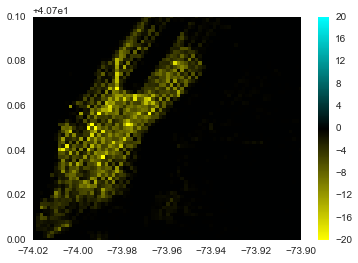

In [179]:
plt.pcolormesh(xBin,yBin,countDiff.T,cmap=cmp)
limits = plt.axis('equal')
plt.colorbar()
plt.clim(-20,20)
plt.xlim(-74.02,-73.90)
plt.ylim(40.70,40.80)